In [52]:

import glob, os
from os import listdir
from os.path import isfile, join
import fnmatch

#Needed for making plots
import matplotlib.pyplot as plt
from matplotlib import pylab
from pylab import *

#Needed for handling lists, arrays, strings, importing data and general math
import numpy as np

In [53]:
from scipy.stats import binned_statistic
def aflare1(t, tpeak, fwhm, ampl, upsample=False, uptime=10):
    '''
    The Analytic Flare Model evaluated for a single-peak (classical).
    Reference Davenport et al. (2014) http://arxiv.org/abs/1411.3723

    Use this function for fitting classical flares with most curve_fit
    tools.

    Note: this model assumes the flux before the flare is zero centered

    Parameters
    ----------
    t : 1-d array
        The time array to evaluate the flare over
    tpeak : float
        The time of the flare peak
    fwhm : float
        The "Full Width at Half Maximum", timescale of the flare
    ampl : float
        The amplitude of the flare
    upsample : bool
        If True up-sample the model flare to ensure more precise energies.
    uptime : float
        How many times to up-sample the data (Default is 10)

    Returns
    -------
    flare : 1-d array
        The flux of the flare model evaluated at each time
    '''
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]

    if upsample:
        dt = np.nanmedian(np.diff(t))
        timeup = np.linspace(min(t)-dt, max(t)+dt, t.size * uptime)

        flareup = np.piecewise(timeup, [(timeup<= tpeak) * (timeup-tpeak)/fwhm > -1.,
                                        (timeup > tpeak)],
                                    [lambda x: (_fr[0]+                       # 0th order
                                                _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                                _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                                _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                                _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                                     lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                                _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                                    ) * np.abs(ampl) # amplitude

        # and now downsample back to the original time...
        ## this way might be better, but makes assumption of uniform time bins
        # flare = np.nanmean(flareup.reshape(-1, uptime), axis=1)

        ## This way does linear interp. back to any input time grid
        # flare = np.interp(t, timeup, flareup)

        ## this was uses "binned statistic"
        downbins = np.concatenate((t-dt/2.,[max(t)+dt/2.]))
        flare,_,_ = binned_statistic(timeup, flareup, statistic='mean',
                                 bins=downbins)

    else:
        flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
                                 (t > tpeak)],
                                [lambda x: (_fr[0]+                       # 0th order
                                            _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                            _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                            _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                            _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                                 lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                            _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                                ) * np.abs(ampl) # amplitude

    return flare

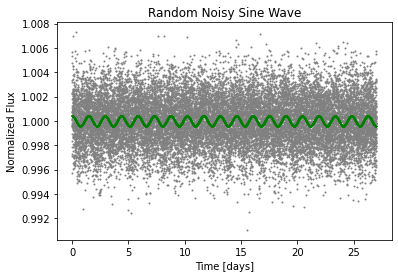

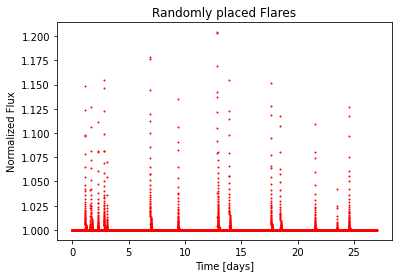

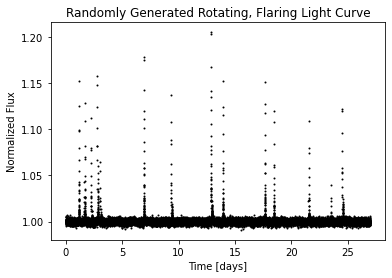

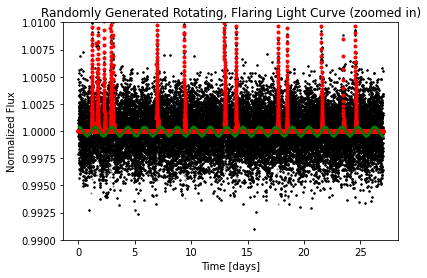

period of variability:  9.159998619610723


In [68]:
ndays = 27 #days
cadence =  2/(60*24) # 2 minute exposure time in units of days
pts_per_day = 1.0/cadence #data points per day
start=0.0
stop=ndays
stepsize=int(np.round(ndays*pts_per_day))
time = np.linspace(start, stop, stepsize) 

#randomizing flux to have random variability and trends

# amplitude= np.random.randint(1.,10)

# minfreq = 2*np.pi/1.0; maxfreq = 2*np.pi/3.0
# frequency =np.random.uniform(minfreq, maxfreq) 
# #^^^ range decided by M-dwarf field star survey
# # https://www.semanticscholar.org/paper/M-DWARF-RAPID-ROTATORS-AND-THE-DETECTION-OF-YOUNG-Rappaport-Swift/1b7e183659ddad11efb23ba68e7d11a0b07f5d1c/figure/0
# offset = time/np.random.randint(1,2) 
# sinewave = np.sin(time*frequency+offset) #simple harmonic oscillation

amplitude= np.random.randint(1.,5)

minP = 6.0 ; maxP = 18 # days

minfreq = 2*np.pi/minP; maxfreq = 2*np.pi/maxP
frequency =np.random.uniform(minfreq, maxfreq) 
offset = time/np.random.randint(1,2) -1.5
sinewave = amplitude*exp(-(time-offset)**2) * np.cos(2.0*np.pi*frequency*time)



linear_trend = (time**np.random.randint(0,2))/np.random.randint(1,2)


# flux =  ( (sinewave +  linear_trend) / 1000) +1
flux =  ( (sinewave) / 1000) +1

noise = np.random.normal(0, 0.002, stepsize)
flux += noise
# add errors
dy = 0.01
error = np.ones_like(flux)*dy #np.random.normal(flux, dy)


# #injecting planet (optional)
# Rad_sun = 6.955*10.0**10.0 #cm
# Rad_earth = 6.378*10.0**8.0 #cm
# Mass_sun = 1.989*10.0**33.0 #grams

# R_star = 0.6 *Rad_sun
# M_star = 0.7*Mass_sun
# time_start = time[51] #[51] =fiftieth data point in array

# # Use batman to create transits
# ma = batman.TransitParams()
# ma.t0 = time_start  # time of inferior conjunction; first transit is X days after start
# ma.per = np.random.uniform(1,5)#2.345  # orbital period
# ma.rp = np.random.uniform(1,5)*Rad_earth/Rad_sun#3.0*Rad_earth/Rad_sun  # planet radius (in units of stellar radii) 
# ma.a =  np.random.uniform(0.001,5)# 5  # semi-major axis (in units of stellar radii)
# ma.inc = 90  # orbital inclination (in degrees)
# ma.ecc = 0  # eccentricity
# ma.w = 90  # longitude of periastron (in degrees)
# ma.u = [0.4, 0.4]  # limb darkening coefficients
# ma.limb_dark = "quadratic"  # limb darkening model
# m = batman.TransitModel(ma, time)  # initializes model
# synthetic_signal = m.light_curve(ma)  # calculates light curve

# injectedflux = synthetic_signal- flux +1

#injecting flares
# set up the quiescent brightness for this fake star
flux0 = [1.0]
err0 = [0.02]
N_flares = [15]

import random
Allflares = 0
for j in range((N_flares[0])):
        tpeak = np.random.random(1)[0] * time.max() # random time
        srand = np.random.uniform(low=0.1, high=0.5) # random size scale of flare, 0-1
        ampl = srand * 0.5 # scale size linearly to amplitude (BAD)
        fwhm = (srand * 60.*27) / (60.*60.*24.) # scale size linearly to FWHM (BAD)
        flares = aflare1(time, tpeak, fwhm, ampl, upsample=True)+1
        # flux = flux + flares
        Allflares=Allflares+flares-1
        injectedflux = flux +Allflares

Allflares=Allflares+1        





plt.title('Random Noisy Sine Wave')
plt.plot(time,( (sinewave) / 1000) +1,'g.-',markersize=0.5)
plt.scatter(time,flux, s=1,color='grey')
plt.xlabel('Time [days]')
plt.ylabel('Normalized Flux')
plt.savefig('noisysine.png',bbox_inches='tight')
plt.show()

plt.title('Randomly placed Flares')
# plt.scatter(time,synthetic_signal,color='blue')
plt.scatter(time,Allflares, s=1,color='red')
plt.xlabel('Time [days]')
plt.ylabel('Normalized Flux')
plt.savefig('randomflares.png',bbox_inches='tight')
plt.show()

plt.title('Randomly Generated Rotating, Flaring Light Curve')
plt.scatter(time, injectedflux, s=1, color='black')
plt.xlabel('Time [days]')
plt.ylabel('Normalized Flux')
plt.savefig('final_sim_lc.png',bbox_inches='tight')
plt.show()

plt.title('Randomly Generated Rotating, Flaring Light Curve (zoomed in)')
plt.scatter(time,flux, s=1,color='grey')
# plt.scatter(time,synthetic_signal,color='blue')
plt.plot(time, injectedflux, 'k.',markersize=3)
plt.plot(time,Allflares, 'r.',zorder=2)
plt.plot(time,( (sinewave) / 1000) +1,'g.-',markersize=0.5)
plt.xlabel('Time [days]')
plt.ylabel('Normalized Flux')
# plt.xlim(0, 15)
plt.ylim(0.99, 1.01);
plt.savefig('final_sim_lc_zoomin.png',bbox_inches='tight')
plt.show();

print("period of variability: ",2*np.pi/frequency)

In [72]:
import pandas as pd

LCDF = pd.DataFrame({"Time":time,"Simulated Rotating and Flaring Flux": injectedflux,"Random sinewave":( (sinewave) / 1000) +1,"Random Flares":Allflares,"Error":error})
LCDF.to_csv('Simulated_Rotating_and_Flaring_LightCurve.csv',index=False)

In [71]:
LCDF

,Time,Simulated Rotating and Flaring Flux,Random sinewave,Random Flares,Error
0,0.000000,0.999586,1.000422,1.0,0.1
1,0.001389,1.004754,1.000422,1.0,0.1
2,0.002778,0.997857,1.000422,1.0,0.1
3,0.004167,1.001061,1.000422,1.0,0.1
4,0.005556,1.000761,1.000421,1.0,0.1
...,...,...,...,...,...
19435,26.994444,1.003385,0.999581,1.0,0.1
19436,26.995833,0.999391,0.999581,1.0,0.1
19437,26.997222,1.000001,0.999581,1.0,0.1
19438,26.998611,1.000309,0.999582,1.0,0.1
